In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
df = pd.read_csv('/kaggle/input/time-series-datasets/Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [47]:
df.shape

(397, 4)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [26]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [27]:
df.columns=["Month","Sales"]
df.head()

,Month,Sales
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [28]:
df.describe()

,Month,Sales
count,397,397.000000
mean,2001-07-01 13:25:14.357682560,88.847218
min,1985-01-01 00:00:00,55.315100
25%,1993-04-01 00:00:00,77.105200
50%,2001-07-01 00:00:00,89.779500
75%,2009-10-01 00:00:00,100.524400
max,2018-01-01 00:00:00,129.404800
std,NaN,15.387834


In [29]:
df.set_index('Month',inplace=True)

In [30]:
df.head()

,Sales
Month,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


<Axes: xlabel='Month'>

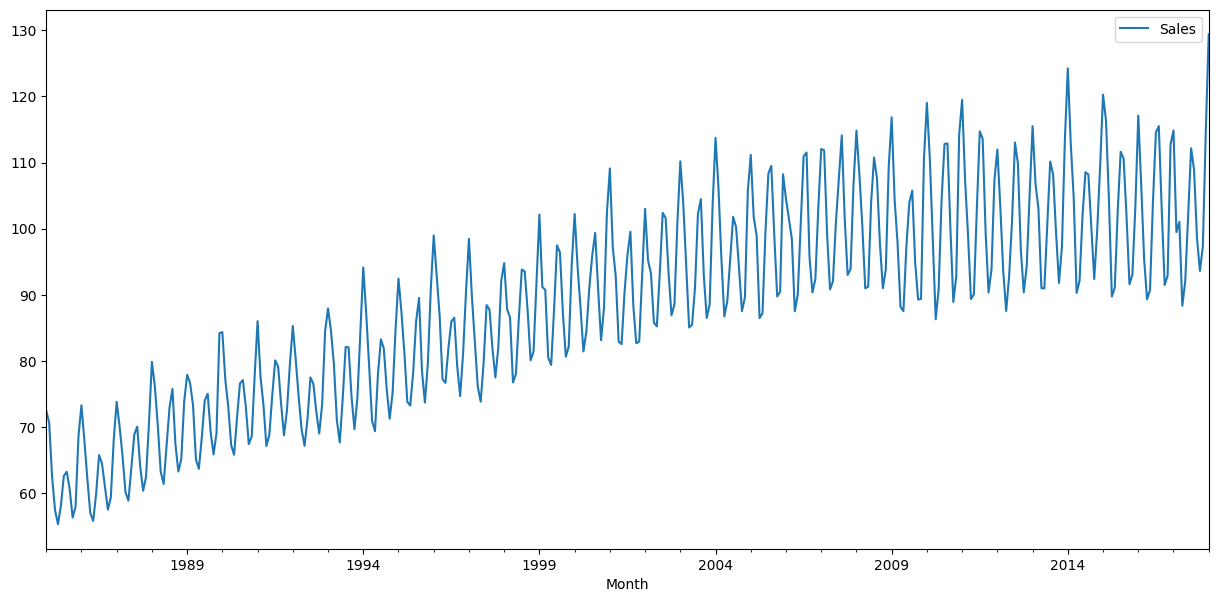

In [31]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df.plot()

## Checking stationary

In [32]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Sales'])

In [33]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['Sales'])

ADF Test Statistic : -2.256990350047235
p-value : 0.1862146911658712
#Lags Used : 15
Number of Observations : 381
weak evidence against null hypothesis,indicating it is non-stationary 


In [34]:
df['Sales First Difference'] = df['Sales'] - df['Sales'].shift(1)
df['Seasonal First Difference']=df['Sales'] - df['Sales'].shift(12)
df.head()

,Sales,Sales First Difference,Seasonal First Difference
Month,,,
1985-01-01,72.5052,NaN,NaN
1985-02-01,70.6720,-1.8332,NaN
1985-03-01,62.4502,-8.2218,NaN
1985-04-01,57.4714,-4.9788,NaN
1985-05-01,55.3151,-2.1563,NaN


In [36]:
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -5.673482023381762
p-value : 8.812644938088861e-07
#Lags Used : 12
Number of Observations : 372
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Axes: xlabel='Month'>

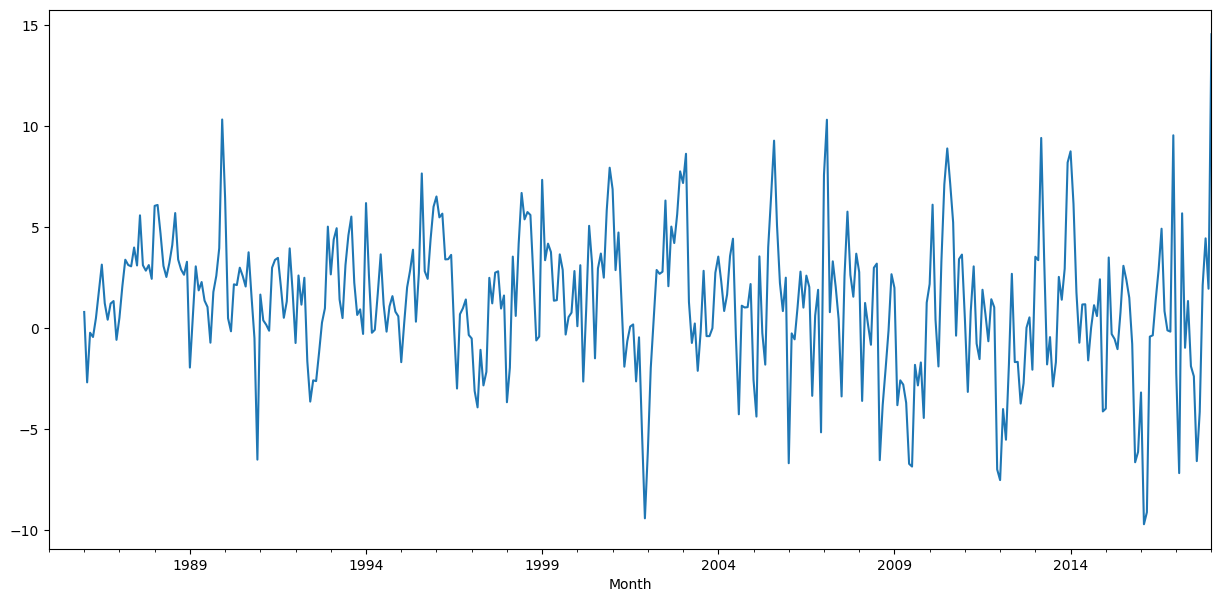

In [37]:
df['Seasonal First Difference'].plot()

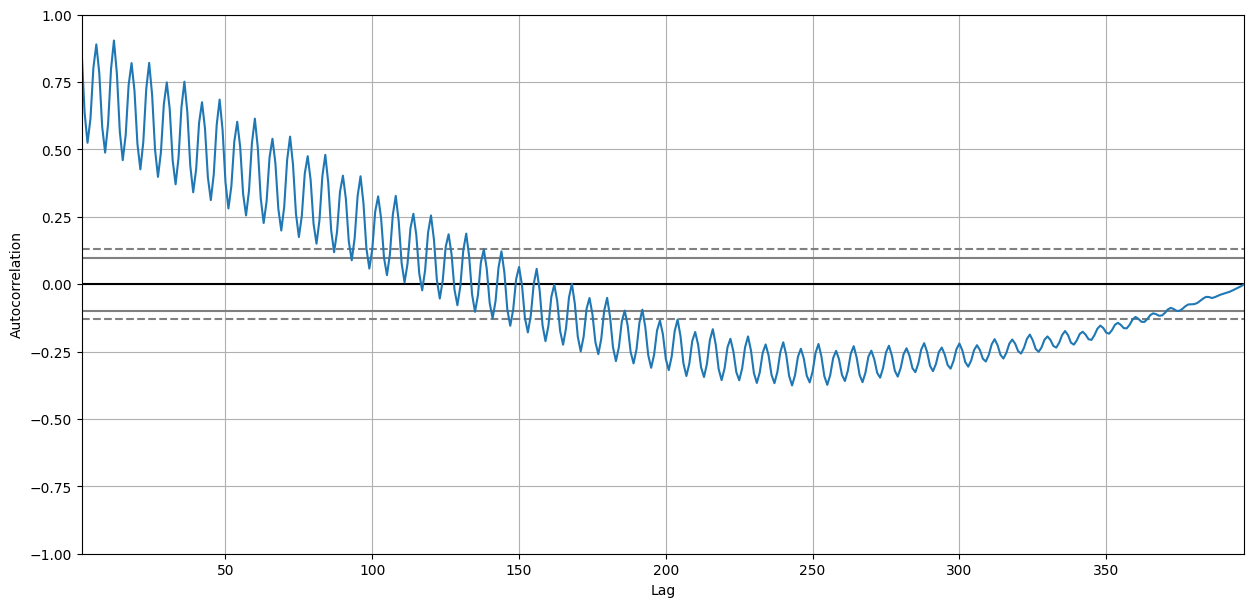

In [38]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Sales'])
plt.show()

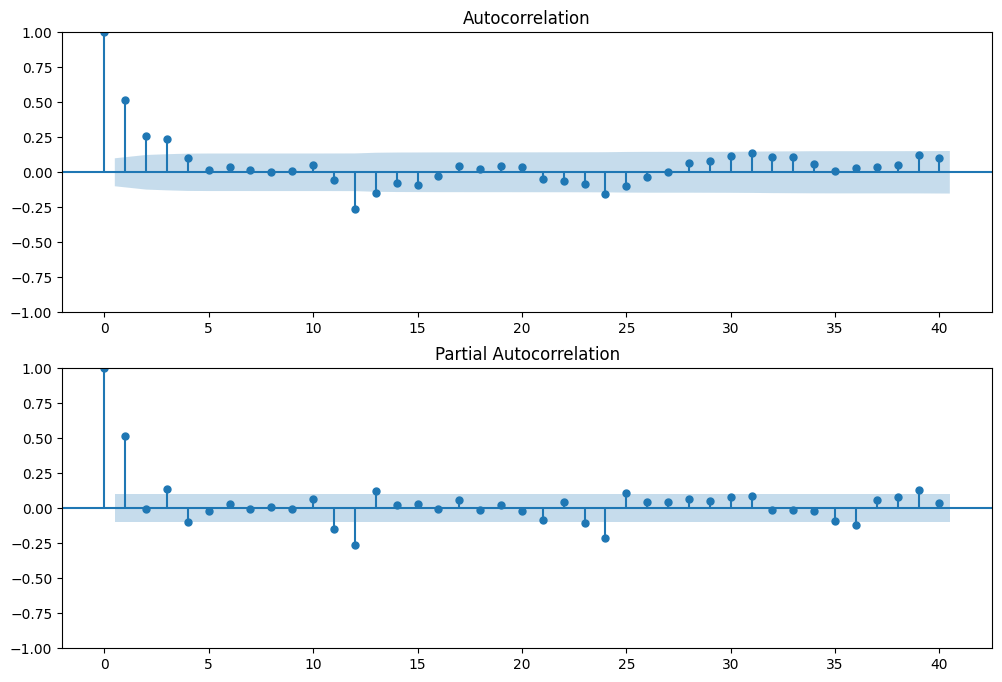

In [39]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

In [40]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(df['Sales'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  397
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1308.795
Date:                Sun, 12 May 2024   AIC                           2623.589
Time:                        06:57:21   BIC                           2635.533
Sample:                    01-01-1985   HQIC                          2628.321
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0732      0.091      0.805      0.421      -0.105       0.251
ma.L1          0.5450      0.070      7.737      0.000       0.407       0.683
sigma2        43.4248      3.296     13.175      0.000      36.965      49.885
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.72   Prob(JB):                         0.49
Heteroskedasticity (H):               2.97   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
start = 385
end = start + 13
start1 = end + 1
end1 = start1 + 13
start, end, start1, end1

(385, 398, 399, 412)

<Axes: xlabel='Month'>

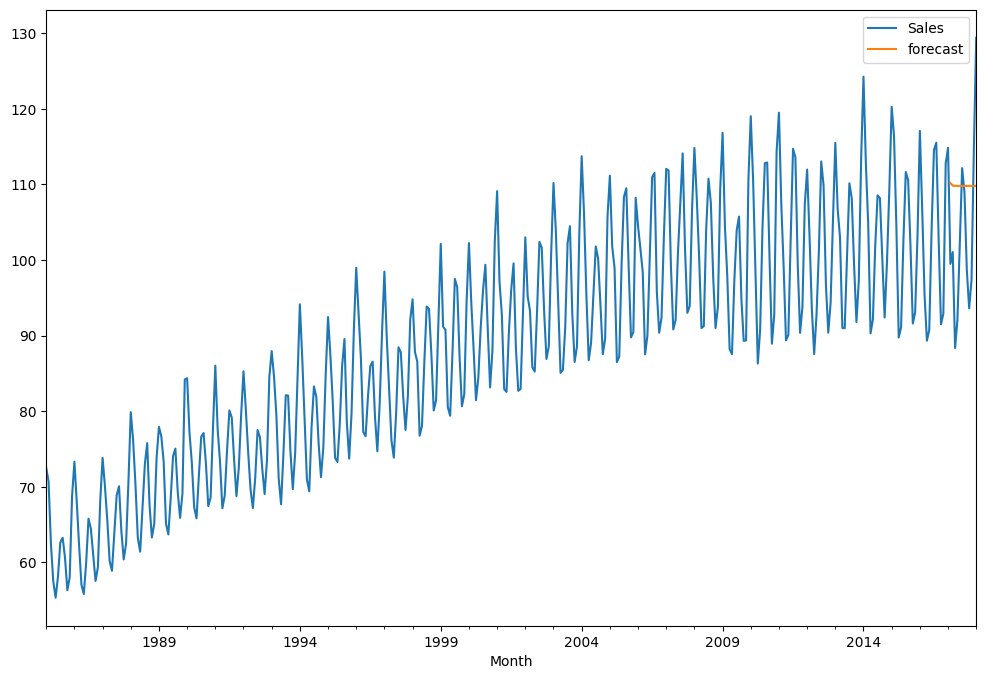

In [55]:
df['forecast']=model_fit.predict(start=start,end=end,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33499D+00    |proj g|=  1.05413D-01

At iterate    5    f=  2.25169D+00    |proj g|=  4.08885D-02

At iterate   10    f=  2.23832D+00    |proj g|=  7.92429D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   6.114D-06   2.238D+00
  F =   2.2383201823969121     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<Axes: xlabel='Month'>

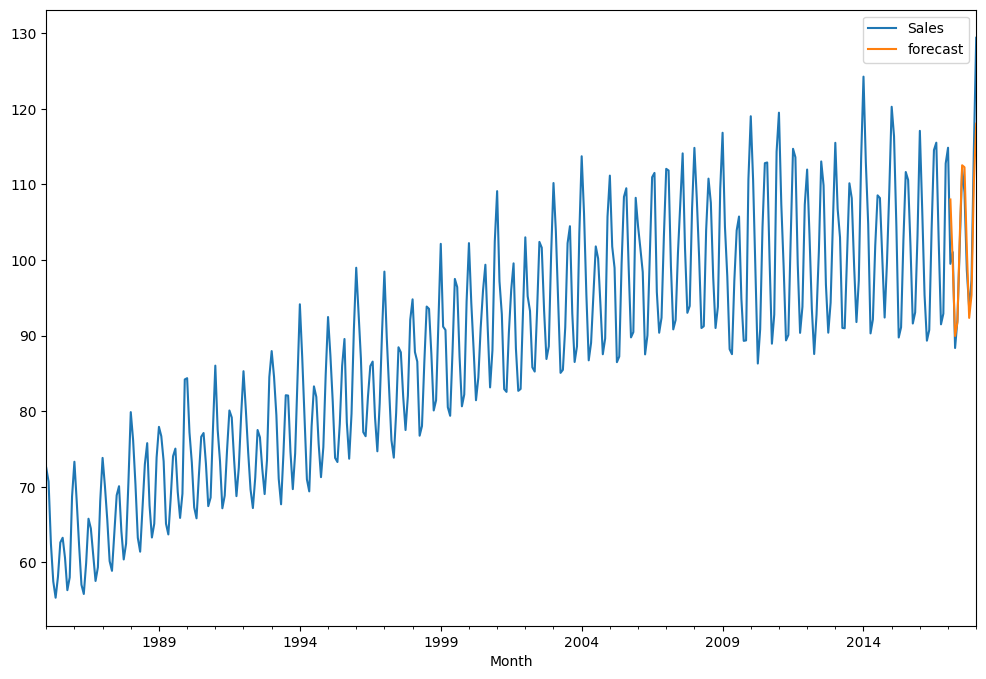

In [56]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=start, end=end, dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

/tmp/ipykernel_33/2683299234.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([df,future_datest_df])
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<Axes: >

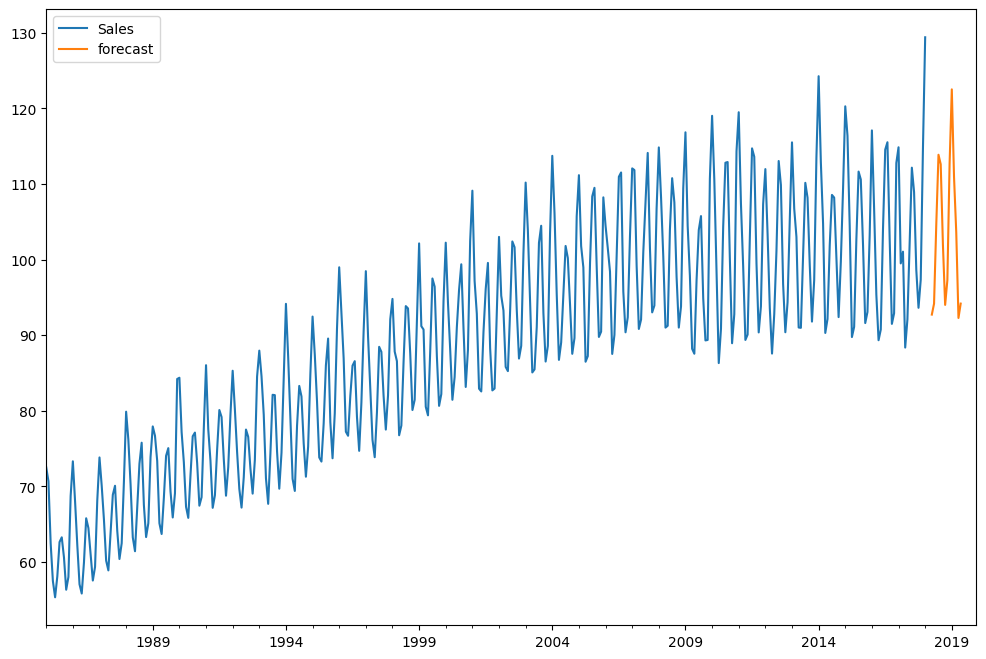

In [57]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['forecast'] = results.predict(start = start1, end = end1, dynamic= True)
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))